# Team 1 - Final Project
## Israel Romero Olvera
#### In this project I'll create a predictive model that will take Midi files from 4 Master composers and classify them by artist name based solely on the musical structure.

In [1]:
#Importing the required libraries
import os
import numpy as np
import random
import pandas as pd
import pretty_midi
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization, Bidirectional, LSTM, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Preparing the directories to load the Midi files
rootdir=r'C:\Users\isral\AAI_511\Composer_Dataset\FinalDataset'

In [3]:
RANDOM_SEED = 75 #Define our random seed for reproducibility
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
# Creating a class to handle the MIDI loading
class MidiDataset:
    def __init__(self, path, num_epochs=10, seq_len=300, fs=10, batch_size=16, allow_repeat=False, verbose=1):
        self.path = path #root folder with subfolders for each composer
        self.seq_len = seq_len #number of time steps per piano roll
        self.fs = fs #frames per second for piano roll
        self.train_samples = [] #placeholder for the training sample midi paths
        self.train_labels = [] #placeholder for the training labels
        self.author_labels_idx = {} #placeholder for the id labels for training
        self.test_samples = [] #placeholder for the testing sample midi paths
        self.test_labels = [] #placeholder for the testing labels
        self.val_samples = [] #placeholder for the validation sample midi paths
        self.val_labels = [] #placeholder for the validation labels
        self.num_epochs = num_epochs #Setting the number of epochs that our model will use
        self.max_samples = 250 #Due to class imbalance, I'm "downsampling" by limiting the number of midi files loaded per author
        self.batch_size = batch_size #Setting the batch size
        self.allow_repeat = allow_repeat #Setting to configure the dataset to allow repeating or not
        self.verbose = verbose
        self._load_data()
    def _load_data(self):
        #First, we load all the files in the provided path into the labels and midi sample paths, as well as creating the catalog of author labels
        labels, self.author_labels_idx, samples = self.load_path(self.path)
        self.plot_authors_distribution(labels, 'All imported midi') #We plot the distribution of melodies per artist
        
        #Setting other internal values
        self.learning_rate = 0.0001 #Establishing the learning rate

        #Split into train (80%), 
        self.train_samples, X_test, self.train_labels, y_test = train_test_split(samples, #Midi sample paths
                                                            labels,                        #Author targets
                                                            test_size=0.2,            #20% of the data (10% for test, 10% for validation)
                                                            random_state=RANDOM_SEED) #Set random seed
        #Next, breaking the temp set in half so validation and testing sets end with 10% of the original set each.
        self.test_samples, self.val_samples, self.test_labels, self.val_labels = train_test_split(X_test, #Midi sample paths
                                                            y_test,                        #Author targets
                                                            test_size=0.5,            #50% of the data (10% for test, 10% for validation from original set)
                                                            random_state=RANDOM_SEED) #Set random seed
        #Next, we prepare the dataset pairs for the model portion
        self.train_dataset = self.get_tf_dataset_train(batch_size=self.batch_size, shuffle=True)
        self.test_dataset = self.get_tf_dataset_test(batch_size=self.batch_size, shuffle=False)
        self.val_dataset = self.get_tf_dataset_val(batch_size=self.batch_size, shuffle=False)
        #self.num_samples_train = self.get_num_samples(self.train_dataset)
        #self.num_samples_test = self.get_num_samples(self.test_dataset)
        #self.num_samples_val = self.get_num_samples(self.val_dataset)
        #Let's prepare the Model definition
        self.model = self.model_builder()
    def plot_authors_distribution(self, train_labels, title):
        df = pd.DataFrame(train_labels, columns=['Author'])
        df.value_counts().sort_index().plot(kind='bar', title = f'Author sample counts - {title}')
        #plt.figure(figsize=(12, 6))
        plt.xticks(rotation = 0)
        plt.ylabel('Frequency')
        plt.xlabel(self.author_labels_idx)
        plt.tight_layout()
        plt.show()
    def load_path(self, path):
        labels = []
        label_to_idx = {}
        samples = []
        tmpCount = 0
        #First, we load all the subfolders list, which represents the authors list
        composer_dirs = [
            directory for directory in os.listdir(self.path)
            if os.path.isdir(os.path.join(self.path, directory))
        ]
        #Next, we load each individual midi file
        for idx, composer in enumerate(composer_dirs):
            label_to_idx[composer] = idx #Here we create a unique ID for each composer
            tmpCount = 0
            #Now, let's load all individual files in each composer's folder
            composer_path = os.path.join(path, composer)
            for fname in os.listdir(composer_path):
                if fname.endswith('.mid') or fname.endswith('.midi'): #Including any .MID or .MIDI files
                    file_path = os.path.join(composer_path, fname)
                    #if self.test_midi_file(file_path) == True: #If it's a valid Midi file, we add it. Otherwise, we skip it
                    if tmpCount < self.max_samples: #We're limiting the number of samples
                        samples.append(file_path)
                        labels.append(idx)
                    tmpCount=tmpCount+1
        return labels, label_to_idx, samples
    ##################################### MIDI FUNCTIONS ###########################################################
    #This function will convert the midi notes into a piano roll. Only pitch and duration of notes will be preserved, but other attributes like note velocity or midi channel will be lost.
    def midi_to_pianoroll(self, midi_path, plot=False):
        #Loading the midi file into memory
        midi_data = self.load_midi(midi_path)
        if not midi_data is None:
            #Getting the first frame with a midi note:
            first_active_frame = self.get_frame_first_note(midi_data)
            #Converting the midi data into a piano roll. By default, the velocity values are preserved
            piano_roll = midi_data.get_piano_roll(fs=self.fs)
            ##Make sure piano roll is binary: note active (1) or inactive (0), losing the velocity attribute: we just care if the note is on or off.
            #piano_roll = (piano_roll > 0).astype(np.float32)
            #Normalizing the velocity value by dividing it by 127
            piano_roll = piano_roll / 127.0
            #Trimming leading silence (anything before the first frame)
            piano_roll = piano_roll[:, first_active_frame:]
            #Transposing to (time, pitch), as TensorFlow will use the first dimension to establish sequenciality
            piano_roll = piano_roll.T
    
            # Pad or truncate to seq_len, to ensure all tensors are the same length (part of the melody might be lost, but the sample of the song should be good enough for classification.
            if piano_roll.shape[0] < self.seq_len:
                pad_width = self.seq_len - piano_roll.shape[0]
                piano_roll = np.pad(piano_roll, ((0, pad_width), (0, 0)))
            else:
                piano_roll = piano_roll[:self.seq_len]
    
            # Keep only 0-127 notes, losing other events like tempo changes, instrument changes, pitch bend, etc.
            # NOTE: while foot switch messages get excluded too, the note duration is preserved in the piano roll as the note state is captured as "ON" by PrettyMIDI.
            piano_roll = piano_roll[:, :128]
            if plot==True:
                self.plot_piano_roll(piano_roll, f'Piano Roll for file {midi_path}')
            return piano_roll
        else:
            return None
    #Creating this function to visually represent a piano roll of a sample
    def plot_piano_roll(self, piano_roll, title="Piano Roll", save_path=None):
        time_steps = piano_roll.shape[0] #Getting the timesteps from the piano roll dynamically
        duration = time_steps / self.fs  #number of seconds
        time_axis = np.linspace(0, duration, time_steps)
        print(f'Time Steps: {time_steps}, Frames per Second: {self.fs} Duration: {duration} s')
        plt.figure(figsize=(12, 6))
        plt.imshow(piano_roll.T, aspect='auto', origin='lower', 
                   extent=[0, duration, 0, 128], cmap='gray_r')
        plt.xlabel('Time (s)')
        plt.ylabel('MIDI Note')
        plt.title(title)
        plt.tight_layout()
        #If specified where to save the image, proceed saving it. Else, show plot it instead.
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()
    def load_midi(self, midi_path):
        try:
            return pretty_midi.PrettyMIDI(midi_path)
        except Exception as e:
            print(f"⚠️ Skipping {midi_path}: {e}")
            return None
    def get_frame_first_note(self, midi_content):
        #Get all note start times
        note_start_times = [note.start for instrument in midi_content.instruments for note in instrument.notes]
        #Get the first note time
        first_note_time = min(note_start_times)
        #Calculate the frame in which the note shows up
        first_frame = int(first_note_time * self.fs)
        #Return the first frame
        return first_frame
    def generator(self, samples, labels):
        #for midi_path, label in zip(self.train_samples, self.train_labels):
        for midi_path, label in zip(samples, labels):
            piano_roll = self.midi_to_pianoroll(midi_path)
            yield piano_roll, label
    #This function builds the TensorFlow dataset
    def get_tf_dataset(self, samples, labels, batch_size=16, shuffle=True):
        output_signature = (
            tf.TensorSpec(shape=(self.seq_len, 128), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
        dataset = tf.data.Dataset.from_generator(
            lambda: self.generator(samples, labels),
            output_signature=output_signature
        )
        #The shuffle parameter will help the Neural Network training by shuffling the sample's order, preventing the model from seeing samples in the same order every epoch
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(samples))
            #dataset = dataset.repeat() #Preparing the dataset to be repeated indefinitely during epochs
            #dataset = dataset.shuffle(buffer_size=len(self.train_samples))
        dataset = dataset.batch(batch_size) #Preparing the dataset in the specified batches
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset
    def get_tf_dataset_train(self, batch_size=16, shuffle=True):
        return self.get_tf_dataset(self.train_samples, self.train_labels, batch_size, shuffle)
    def get_tf_dataset_test(self, batch_size=16, shuffle=False):
        return self.get_tf_dataset(self.test_samples, self.test_labels, batch_size, shuffle)
    def get_tf_dataset_val(self, batch_size=16, shuffle=False):
        return self.get_tf_dataset(self.val_samples, self.val_labels, batch_size, shuffle)
    def test_midi_file(self, file):
        tmpOpen = self.load_midi(file)
        if tmpOpen == None:
            return False
        return True
    #################################################### MODEL FUNCTIONS #######################################################
    def model_builder(self):
        #This function will implement the architecture selected as parameter for the class
        n_classes = len(self.author_labels_idx)
        model = models.Sequential([
            layers.Input(shape=(self.seq_len, 128)),
    
            #CNN block: extract short-term temporal & note patterns
            layers.Conv1D(filters=64, kernel_size=9, dilation_rate=2, activation='relu', padding='same'),
            layers.MaxPooling1D(pool_size=4), #Since my sequence is long, I'm downsampling it by a factor of 4
            #To improve efficiency, we'll normalize the activations.
            #BatchNormalization(),
            LayerNormalization(),
            layers.Dropout(0.1),

            #Second CNN layer
            layers.Conv1D(filters=128, kernel_size=3, dilation_rate=2, activation='relu', padding='same'),
            layers.MaxPooling1D(pool_size=3), #Now we will downsample the next layer by a factor of 3
            #To improve efficiency, we'll normalize the activations.
            #BatchNormalization(),
            LayerNormalization(),
            layers.Dropout(0.1),

            #Third CNN layer
            #layers.Conv1D(filters=256, kernel_size=3, dilation_rate=2, activation='relu', padding='same'),
            #layers.MaxPooling1D(pool_size=2),
            #To improve efficiency, we'll normalize the activations.
            #LayerNormalization(),
            #layers.Dropout(0.3),

            #LSTM layer: this will extract the patterns from the midi samples
            #layers.LSTM(128, return_sequences=True),  #First LSTM
            Bidirectional(layers.LSTM(256, return_sequences=True)),  #First LSTM
            Bidirectional(layers.LSTM(128, return_sequences=True)),  #Second LSTM
            Bidirectional(layers.LSTM(64, return_sequences=False)), #Second LSTM
    
            # Fully connected classification head
            layers.Dense(64, activation='linear'),
            layers.Dropout(0.3),
            layers.Dense(n_classes, activation='softmax')
        ])
        return model
    def train(self):
        #In this method, the class will compile the model and train it using the training set, returning the evaluation metrics.
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), metrics=['accuracy'])
        #Next, print the model summary
        self.model.summary()

        #Calculating the values for the epoch and validation steps
        train_steps = len(self.train_samples) // self.batch_size
        val_steps = len(self.val_samples) // self.batch_size
        
        #Preparing the Early Stopping if needed
        early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

        #Now, calculating the history after fitting the model with the training set
        history = self.model.fit(
            self.train_dataset,
            validation_data=self.val_dataset,
            epochs=self.num_epochs,
            steps_per_epoch=train_steps,
            #batch_size=self.batch_size,
            validation_steps=val_steps,
            callbacks=[early_stopping],
            verbose=self.verbose
        )
        return self.evaluate(self.train_dataset, 'Training Dataset')

    def predict(self, dataset):
        #This method allows the model to predict the target outputs for the input X
        predictions = self.model.predict(dataset) #We execute and store the predictions
        predicted_labels = np.argmax(predictions, axis=1)
        return predicted_labels
    def test(self):
        #This method evaluates the predictions built with the testing set
        return self.evaluate(self.test_dataset, 'Testing Dataset')

    def evaluate(self, dataset, title=''):
        #This method evaluates the performance of the ANN with the selected parameters
        pred_labels = self.predict(dataset) #First, we perform the predictions
        true_labels = []
        #Next, we'll get the true labels directly from the dataset, which contains the tensor-label pair
        for _, label_batch in dataset:
            true_labels.extend(label_batch.numpy())
        true_labels = np.array(true_labels)
        #Then, we used the actual values and predicted values to calculate all metrics
        accuracy = accuracy_score(true_labels, pred_labels)
        if not title == '':
            self.print_confusion_matrix(true_labels, pred_labels, title)
        #precision = precision_score(y, y_pred, average='weighted', zero_division=0)
        #recall = recall_score(y, y_pred, average='weighted')
        #f1 = f1_score(y, y_pred, average='weighted')
        #rocauc = roc_auc_score(y, y_pred)
        #Finally, we return the metrics
        #return np.round((accuracy, precision, recall, f1, rocauc), decimals=2)
        return np.round(accuracy, decimals=2)
    def get_num_samples(self, dataset):
        sample_count = sum(1 for _ in dataset)
        return sample_count
    def print_num_samples(self):
        print(f'Training samples: {self.num_samples_train}, Testing samples: {self.num_samples_test}, Val samples: {self.num_samples_val}.')
    def print_confusion_matrix(self, true_labels, predicted_labels, title):
        cm = confusion_matrix(true_labels, predicted_labels)
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=self.author_labels_idx.keys(), yticklabels=self.author_labels_idx.keys())
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {title}')
        plt.show()

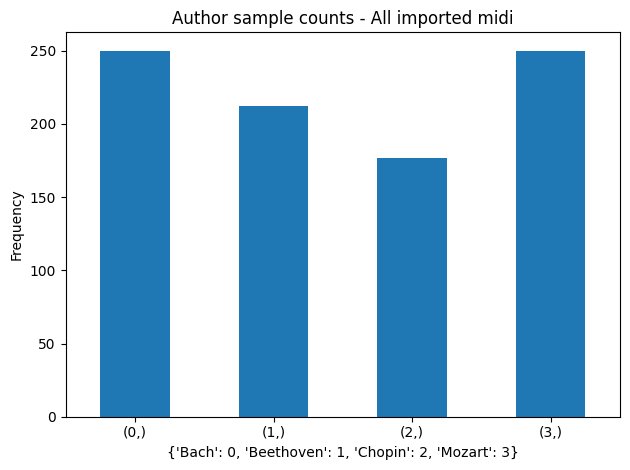

In [4]:
#For the model, I'll use 15 epochs, a frequency of 40 frames per second, and a duration of 60 seconds, which at 40 fps would be 2400 frames
midi_model = MidiDataset(path=rootdir, num_epochs=15, seq_len=600, fs=10, batch_size=16, allow_repeat=False, verbose=1)

Time Steps: 600, Frames per Second: 10 Duration: 60.0 s


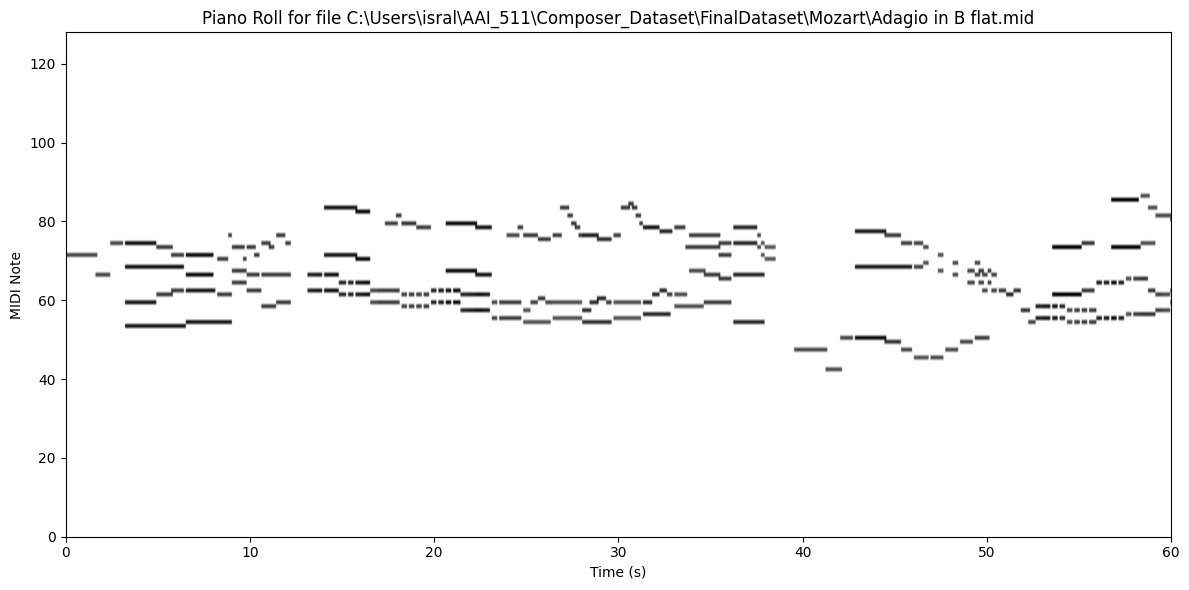

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
#Plotting a Piano Roll
midi_model.midi_to_pianoroll(midi_model.val_samples[0], plot=True)

In [6]:
training_accuracy = midi_model.train()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 600, 64)        │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 150, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 150, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 50, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50, 4)          │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,396 (419.52 KB)

 Trainable params: 107,396 (419.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None,), output.shape=(None, 50, 4)

In [ ]:
testing_accuracy = midi_model.test()

In [ ]:
print(f'Training accuracy: {training_accuracy}')
print(f'Testing accuracy: {testing_accuracy}')

In [ ]:
for piano_rolls, labels in midi_model.train_dataset.take(1):
    print('Batch piano_rolls shape:', piano_rolls.shape)  # (batch_size, seq_len, 128)
    print('Batch labels:', labels)                        # (batch_size,)
    print('Labels batch shape:', labels.shape)

for piano_rolls, labels in midi_model.test_dataset.take(1):
    print('Batch piano_rolls shape:', piano_rolls.shape)  # (batch_size, seq_len, 128)
    print('Batch labels:', labels)                        # (batch_size,)
    print('Labels batch shape:', labels.shape)
for piano_rolls, labels in midi_model.val_dataset.take(1):
    print('Batch piano_rolls shape:', piano_rolls.shape)  # (batch_size, seq_len, 128)
    print('Batch labels:', labels)                        # (batch_size,)
    print('Labels batch shape:', labels.shape)


C:\Users\isral\.conda\envs\IRO\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Batch piano_rolls shape: (64, 2400, 128)
Batch labels: tf.Tensor(
[0 3 1 1 0 2 2 1 2 1 3 0 1 0 0 3 0 3 1 1 0 1 2 1 3 2 3 3 0 1 0 3 0 0 3 1 2
 3 1 1 2 3 2 0 3 0 0 2 1 1 3 0 3 0 2 1 0 0 2 2 3 1 2 2], shape=(64,), dtype=int32)
Labels batch shape: (64,)
Batch piano_rolls shape: (64, 2400, 128)
Batch labels: tf.Tensor(
[3 2 3 2 3 1 2 1 0 2 3 1 3 0 1 0 3 3 2 0 0 3 2 0 1 0 1 0 3 1 3 3 3 0 2 0 3
 0 1 0 3 3 1 0 2 3 3 0 1 0 0 0 0 0 1 0 3 3 0 2 1 3 1 0], shape=(64,), dtype=int32)
Labels batch shape: (64,)


In [ ]:
print(train_dataset.element_spec)
print(test_dataset.element_spec)
print(val_dataset.element_spec)

In [ ]:
sample_count = 0
for piano_rolls, labels in val_dataset:
    sample_count += piano_rolls.shape[0]  # Number of samples in this batch

print("Total samples:", sample_count)